# Decision Tree model

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, recall_score
from sklearn.tree import DecisionTreeClassifier

random_state = 69420
np.random.seed(random_state)

test_size = 0.2

In [5]:
data = pd.read_csv('data/train_processed.csv')
target = "Machine failure"

In [6]:
X = data.drop(columns=[target], axis=1)
y = data[target]

In [7]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=random_state)

print(f"Train size: {len(Xtr)}")
print(f"Test size: {len(Xte)}")

Train size: 108891
Test size: 27223


### Baseline

In [8]:
base_dt = DecisionTreeClassifier(random_state=random_state)
base_dt.fit(Xtr, ytr);

In [9]:
ypred = base_dt.predict(Xte)
print(f"Testing accuracy: {accuracy_score(yte, ypred):.3%}")

Testing accuracy: 97.914%


In [10]:
print("Feature importances:")
for i, imp in enumerate(base_dt.feature_importances_):
    print(f"\t{X.columns[i]}: {imp:.3f}")

Feature importances:
	id: 0.188
	Air temperature [K]: 0.150
	Process temperature [K]: 0.121
	Rotational speed [rpm]: 0.162
	Torque [Nm]: 0.231
	Tool wear [min]: 0.149


In [11]:
base_depth = base_dt.get_depth()
print(f"Tree depth: {base_depth}")

Tree depth: 34


In [12]:
y_pred = base_dt.predict(Xte)

In [13]:
print(classification_report(yte,y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26841
           1       0.31      0.38      0.34       382

    accuracy                           0.98     27223
   macro avg       0.65      0.68      0.66     27223
weighted avg       0.98      0.98      0.98     27223



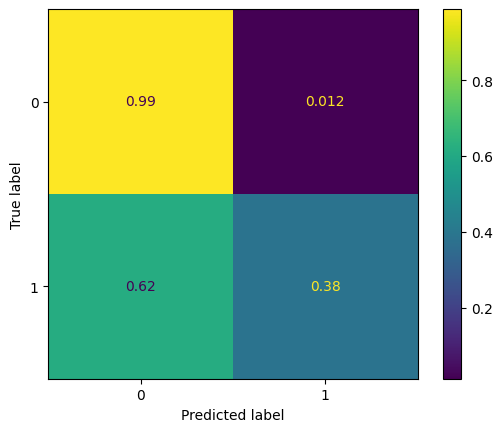

In [14]:
ConfusionMatrixDisplay.from_estimator(base_dt, Xte, yte, display_labels=base_dt.classes_, normalize="true");

### Grid search #1

In [49]:
def grid_search(params, scores):
    skf = StratifiedKFold(n_splits=3, random_state=random_state, shuffle=True)
    results = {}

    for score in scores:
        print(f"Tuning hyperparameters for: {score}...", end="")
        
        clf = GridSearchCV(estimator=base_dt,
                        param_grid=params,
                        scoring=score,
                        return_train_score=False,
                        cv=skf,)
        
        clf.fit(Xtr, ytr)
        
        best_model = clf.best_estimator_
        classes = best_model.classes_
        
        y_pred = best_model.predict(Xte)
        
        report = classification_report(yte,y_pred, zero_division=0)
        cm = confusion_matrix(yte, y_pred, labels=classes, normalize="true")

        results[score] = {
            "model": best_model,
            "report": report,
            "matrix": cm
        }

        print("done")

    return results

In [50]:
def print_gridsearch_results(results):
    for score, res in results.items():
        print("-" * 20)
        print(f"Score: {score}")

        print("Classification report:")
        print(res["report"])

        print(f"Best parameters:")
        print(*[f"\t{n}: {v}" for n, v in res["model"].get_params().items()], sep="\n")

        print()

        print("Feature importances:")
        for i, imp in enumerate(res["model"].feature_importances_):
            print(f"\t{X.columns[i]}: {imp:.3f}")

        disp = ConfusionMatrixDisplay(res["matrix"], display_labels=res["model"].classes_)
        disp.plot()
        
        disp.ax_.set_title(f"Optimized for '{score}'")
        disp.ax_.grid(False)

In [51]:
# Set the parameters by cross-validation
params1 = [{'max_depth': [*range(4,base_depth+1)],
           'criterion' : ['entropy', 'gini'],
           "class_weight": [None, "balanced"]
           }]

scores1 = [
          'accuracy',
          'precision_macro',
          'recall_macro',
          'f1_macro'
          ]

results1 = grid_search(params1, scores1)

Tuning hyperparameters for: accuracy...

done
Tuning hyperparameters for: precision_macro...done
Tuning hyperparameters for: recall_macro...done
Tuning hyperparameters for: f1_macro...done


--------------------
Score: accuracy
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26841
           1       0.60      0.32      0.42       382

    accuracy                           0.99     27223
   macro avg       0.79      0.66      0.70     27223
weighted avg       0.98      0.99      0.99     27223

Best parameters:
	ccp_alpha: 0.0
	class_weight: None
	criterion: entropy
	max_depth: 7
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	monotonic_cst: None
	random_state: 69420
	splitter: best

Feature importances:
	Air temperature [K]: 0.145
	Process temperature [K]: 0.051
	Rotational speed [rpm]: 0.381
	Torque [Nm]: 0.273
	Tool wear [min]: 0.150
--------------------
Score: precision_macro
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99  

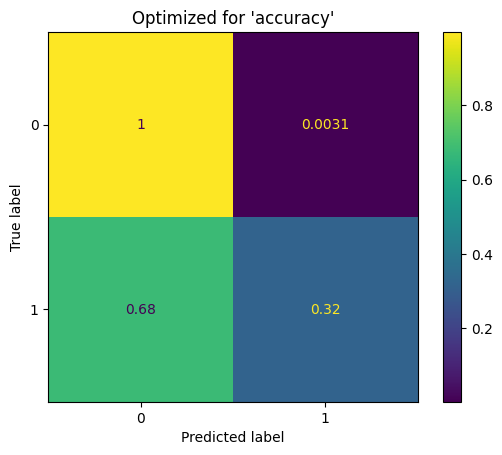

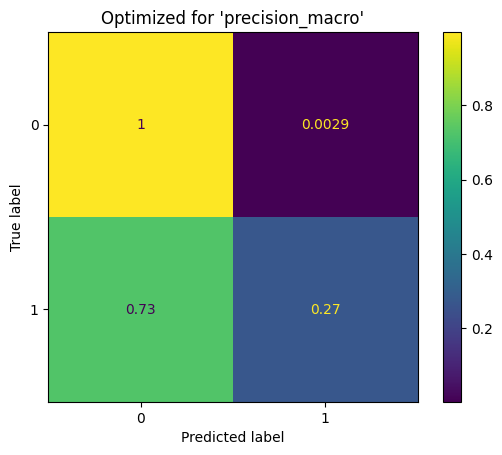

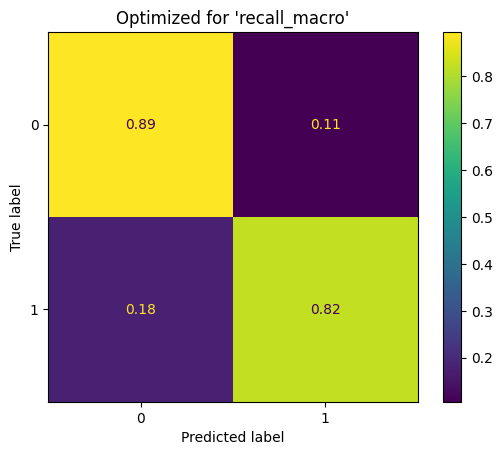

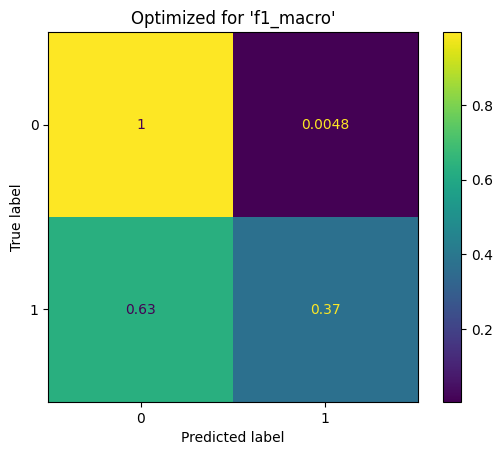

In [52]:
print_gridsearch_results(results1)

From the confusion matrices, we see that the best model is the one optimizing the "recall_macro" metric, which, for the optimized parameters, uses:

- `max_depth` : 4
- `criterion` : `gini`
- `class_weight` : `balanced`

### Grid search #2

The previous best model had, however, a lower accuracy (89%) compared to the base model (97.8%) - which in turn had a significantly lower recall macro average of 68%. We use a custom scoring function to find the Decision Tree model that optimizes the recall macro while keeping accuracy at least at 90%

In [53]:
def accu_recall_scorer(y_true, y_pred, min_accuracy):
    accuracy = accuracy_score(y_true, y_pred)
    recall_macro = recall_score(y_true, y_pred, average='macro')
    
    # Penalize if accuracy falls below 90%
    if accuracy < min_accuracy:
        return 0
    
    # Return recall_macro otherwise
    return recall_macro

accu_recall = make_scorer(accu_recall_scorer, min_accuracy=0.9)

In [54]:
# Set the parameters by cross-validation
params2 = [{'max_depth': [*range(4,base_depth+1)],
           'criterion' : ['gini'],
           "class_weight": ["balanced"]
           }]

scores2 = [accu_recall]

results2 = grid_search(params2, scores2)

Tuning hyperparameters for: make_scorer(custom_scorer, response_method='predict', min_accuracy=0.9)...done


In [ ]:
# Set the parameters by cross-validation
params2 = [{'max_depth': [*range(4,base_depth+1)],
           'criterion' : ['gini'],
           "class_weight": ["balanced"]
           }]

scores2 = [accu_recall]

results2 = grid_search(params2, scores2)

Tuning hyperparameters for: make_scorer(custom_scorer, response_method='predict', min_accuracy=0.9)...done


--------------------
Score: make_scorer(custom_scorer, response_method='predict', min_accuracy=0.9)
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     26841
           1       0.12      0.81      0.21       382

    accuracy                           0.91     27223
   macro avg       0.56      0.86      0.58     27223
weighted avg       0.98      0.91      0.94     27223

Best parameters:
	ccp_alpha: 0.0
	class_weight: balanced
	criterion: gini
	max_depth: 5
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	monotonic_cst: None
	random_state: 69420
	splitter: best

Feature importances:
	Air temperature [K]: 0.027
	Process temperature [K]: 0.001
	Rotational speed [rpm]: 0.619
	Torque [Nm]: 0.161
	Tool wear [min]: 0.192


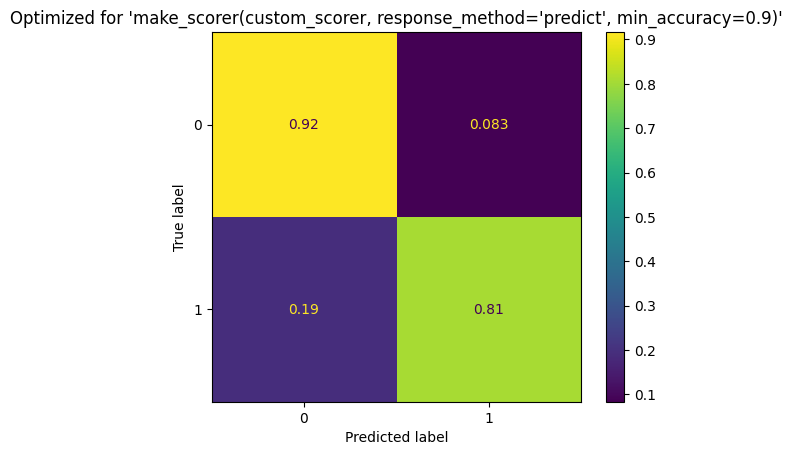

In [55]:
print_gridsearch_results(results2)